# Pratishtha Singh-8927578830

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

### (a) Test Train Split

In [567]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings(action='ignore')
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
cols=['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean',
      'concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se',
     'area_se', 'smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se',
      'radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst',
     'concave points_worst','symmetry_worst','fractal_dimension_worst']
df=pd.read_csv("breast_cancer_data.csv",usecols=cols)
df['diagnosis']=df['diagnosis'].map({'M':1,'B':0})
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [241]:
print(df["diagnosis"].value_counts())

0    357
1    212
Name: diagnosis, dtype: int64


In [246]:
def test_train_split(df,M_pos,B_neg):
    malignant_data = df.loc[df["diagnosis"] == 1]    
    benign_data = df.loc[df["diagnosis"] == 0]
    test_data=pd.concat([malignant_data.head(M_pos),benign_data.head(B_neg)])
    train_data=pd.concat([malignant_data.tail(malignant_data.shape[0]-M_pos),benign_data.tail(benign_data.shape[0]-B_neg)])
    return train_data,test_data
train_data,test_data=test_train_split(df,43,72)
train_y=train_data.iloc[:,0:1]
train_x=train_data.iloc[:,1:31]
test_y=test_data.iloc[:,0:1]
test_x=test_data.iloc[:,1:31]

### (b) (i) Monte-Carlo Simulation-Supervised Learning

In [729]:
acc_score_train=[]
acc_score_test=[]
pscore_train=[]
pscore_test=[]
rscore_train=[]
rscore_test=[]
f1score_train=[]
f1score_test=[]
auc_train=[]
auc_test=[]
for m in range(1,31):
    malignant_data = df.loc[df["diagnosis"] == 1]    
    benign_data = df.loc[df["diagnosis"] == 0]
    test_data=pd.concat([malignant_data.sample(frac=0.2),benign_data.sample(frac=0.2)])
    test_index=test_data.index
    train_data=df.drop(index=test_index)
    train_y=train_data.iloc[:,0:1]
    train_x=train_data.iloc[:,1:31]
    test_y=test_data.iloc[:,0:1]
    test_x=test_data.iloc[:,1:31]
    normalized_train_x=preprocessing.normalize(train_x)
    normalized_test_x=preprocessing.normalize(test_x)
    
    C = np.logspace(-3, 3, 9)
    svm_linear_model=svm.LinearSVC(penalty='l1',dual=False)
    tuned_paramater=dict(C=C)
    gscv=GridSearchCV(svm_linear_model, tuned_paramater, cv=5, n_jobs=-1)
    gscv.fit(normalized_train_x,train_y)
    best_c=gscv.best_estimator_.get_params()['C']

    
    cclf=CalibratedClassifierCV(gscv.best_estimator_)
    cclf.fit(normalized_train_x,train_y)
    ypred_train=cclf.predict(normalized_train_x)
    ypred_test=cclf.predict(normalized_test_x)

    acc_sc_train=cclf.score(normalized_train_x,train_y)
    acc_sc_test=cclf.score(normalized_test_x,test_y)
    acc_score_train.append(acc_sc_train)
    acc_score_test.append(acc_sc_test)
    avg_acc_score_train=np.mean(acc_score_train)
    avg_acc_score_test=np.mean(acc_score_test)
    
    p_score_train=precision_score(train_y,ypred_train,average='macro')
    p_score_test=precision_score(test_y,ypred_test,average='macro')
    pscore_train.append(p_score_train)
    pscore_test.append(p_score_test)
    avg_pscore_train=np.mean(pscore_train)
    avg_pscore_test=np.mean(pscore_test)
    
    r_score_train=recall_score(train_y,ypred_train,average='macro')
    r_score_test=recall_score(test_y,ypred_test,average='macro')
    rscore_train.append(r_score_train)
    rscore_test.append(r_score_test)
    avg_rscore_train=np.mean(rscore_train)
    avg_rscore_test=np.mean(rscore_test)

    f1_score_train=f1_score(train_y,ypred_train,average='macro')
    f1_score_test=f1_score(test_y,ypred_test,average='macro')
    f1score_train.append(f1_score_train)
    f1score_test.append(f1_score_test)
    avg_f1score_train=np.mean(f1score_train)
    avg_f1score_test=np.mean(f1score_test)

    yscore_train=cclf.predict_proba(normalized_train_x)
    yscore_test=cclf.predict_proba(normalized_test_x)
    auc_tr = roc_auc_score(train_y, yscore_train[:,1])
    auc_te = roc_auc_score(test_y, yscore_test[:,1])
    auc_train.append(auc_tr)
    auc_test.append(auc_te)
    avg_auc_train=np.mean(auc_train)
    avg_auc_test=np.mean(auc_test)

print("Average Accuracy Score on Train Data=",avg_acc_score_train)
print("Average Accuracy Score on Test Data=",avg_acc_score_test)
print("Average Precision Score on Train Data=",avg_pscore_train)
print("Average Precision Score on Test Data=",avg_pscore_test)
print("Average Recall Score on Train Data=",avg_rscore_train)
print("Average Recall Score on Test Data=",avg_rscore_test)
print("Average F1 Score on Train Data=",avg_f1score_train)
print("Average F1 Score on Test Data=",avg_f1score_test)
print("Average AUC on Train Data=",avg_auc_train)
print("Average AUC on Test Data=",avg_auc_test)

Average Accuracy Score on Train Data= 0.962207602339181
Average Accuracy Score on Test Data= 0.9427728613569323
Average Precision Score on Train Data= 0.9625567323280887
Average Precision Score on Test Data= 0.9431272923984771
Average Recall Score on Train Data= 0.9564712738242153
Average Recall Score on Test Data= 0.9348479767493851
Average F1 Score on Train Data= 0.9593338753787297
Average F1 Score on Test Data= 0.9381904595948448
Average AUC on Train Data= 0.9958028246263539
Average AUC on Test Data= 0.9908786049631119


CalibratedClassifierCV reference from https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python

Confusion Matrix on Train Data=
[[280   6]
 [ 12 158]]


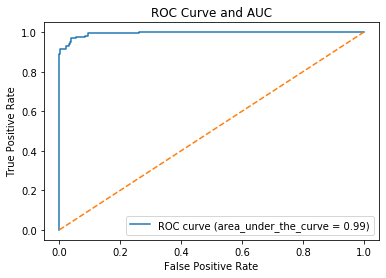

In [730]:
print("Confusion Matrix on Train Data=")
print(confusion_matrix(train_y,ypred_train))

fpr_train, tpr_train, threashold = roc_curve(train_y,yscore_train[:,1])
area_under_the_curve = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, label='ROC curve (area_under_the_curve = %0.2f)' % area_under_the_curve)
plt.plot([0,1], [0,1], "--")
plt.title("ROC Curve and AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Here,the values for the confusion matrix are: True Negative=280,False Positive=6,False Negative=12,True Positive=158

Confusion Matrix on Test Data=
[[71  0]
 [ 5 37]]


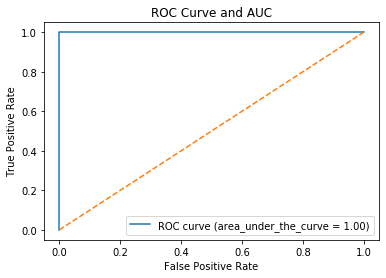

In [731]:
print("Confusion Matrix on Test Data=")
print(confusion_matrix(test_y,ypred_test))

fpr_test, tpr_test, threashold = roc_curve(test_y,yscore_test[:,1])
area_under_the_curve = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, label='ROC curve (area_under_the_curve = %0.2f)' % area_under_the_curve)
plt.plot([0,1], [0,1], "--")
plt.title("ROC Curve and AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Here,the values for the confusion matrix are: True Negative=71,False Positive=0,False Negative=5,True Positive=37

### (b) (ii) Monte-Carlo Simulation-Semi-Supervised Learning

In [732]:
%%time
acc_score_train=[]
acc_score_test=[]
pscore_train=[]
pscore_test=[]
rscore_train=[]
rscore_test=[]
f1score_train=[]
f1score_test=[]
auc_train=[]
auc_test=[]
for m in range(1,31):
    malignant_df = df.loc[df["diagnosis"] == 1]    
    benign_df = df.loc[df["diagnosis"] == 0]
    train_df=pd.concat([malignant_df.sample(frac=0.5),benign_df.sample(frac=0.5)])
    tr_index=train_df.index
    unlabelled_x=df.drop(index=tr_index,columns='diagnosis')
    semi_train_y=train_df.iloc[:,0:1].values
    semi_train_x=train_df.iloc[:,1:31]
    nlabelled_train_x=preprocessing.normalize(semi_train_x)

    C = np.logspace(-3, 3, 9)
    svm_linear_model=svm.LinearSVC(penalty='l1',dual=False)
    tuned_paramater=dict(C=C)
    gscv=GridSearchCV(svm_linear_model, tuned_paramater, cv=5, n_jobs=-1)
    gscv.fit(nlabelled_train_x,semi_train_y)


    y=gscv.decision_function(unlabelled_x)
    while(len(y!=0)):
        farthest_point_index=(np.absolute(y)).argmax()      # argmax() to get the indexes
        unlabelled_x_datapoint=unlabelled_x.iloc[farthest_point_index]
        reshaped_unlabelled_datapoint=unlabelled_x_datapoint.values.reshape(1,-1)
        gscv.best_estimator_.fit(nlabelled_train_x,semi_train_y)
        y_pred=gscv.predict(reshaped_unlabelled_datapoint)
        semi_train_y=np.append(semi_train_y,y_pred)
        nlabelled_train_x=np.append(nlabelled_train_x,reshaped_unlabelled_datapoint,axis=0)
        y=np.delete(y,farthest_point_index)

    cclf=CalibratedClassifierCV(gscv.best_estimator_)
    cclf.fit(nlabelled_train_x,semi_train_y)
    ypred_train=cclf.predict(nlabelled_train_x)
    ypred_test=cclf.predict(normalized_test_x)
       
    acc_sc_train=cclf.score(nlabelled_train_x,semi_train_y)
    acc_sc_test=cclf.score(normalized_test_x,test_y)
    acc_score_train.append(acc_sc_train)
    acc_score_test.append(acc_sc_test)
    avg_acc_score_train=np.mean(acc_score_train)
    avg_acc_score_test=np.mean(acc_score_test)
    
    p_score_train=precision_score(semi_train_y,ypred_train,average='macro')
    p_score_test=precision_score(test_y,ypred_test,average='macro')
    pscore_train.append(p_score_train)
    pscore_test.append(p_score_test)
    avg_pscore_train=np.mean(pscore_train)
    avg_pscore_test=np.mean(pscore_test)
    
    r_score_train=recall_score(semi_train_y,ypred_train,average='macro')
    r_score_test=recall_score(test_y,ypred_test,average='macro')
    rscore_train.append(r_score_train)
    rscore_test.append(r_score_test)
    avg_rscore_train=np.mean(rscore_train)
    avg_rscore_test=np.mean(rscore_test)

    f1_score_train=f1_score(semi_train_y,ypred_train,average='macro')
    f1_score_test=f1_score(test_y,ypred_test,average='macro')
    f1score_train.append(f1_score_train)
    f1score_test.append(f1_score_test)
    avg_f1score_train=np.mean(f1score_train)
    avg_f1score_test=np.mean(f1score_test)

    yscore_train=cclf.predict_proba(nlabelled_train_x)
    yscore_test=cclf.predict_proba(normalized_test_x)
    auc_tr = roc_auc_score(semi_train_y, yscore_train[:,1])
    auc_te = roc_auc_score(test_y, yscore_test[:,1])
    auc_train.append(auc_tr)
    auc_test.append(auc_te)
    avg_auc_train=np.mean(auc_train)
    avg_auc_test=np.mean(auc_test)

print("Average Accuracy Score on Train Data=",avg_acc_score_train)
print("Average Accuracy Score on Test Data=",avg_acc_score_test)
print("Average Precision Score on Train Data=",avg_pscore_train)
print("Average Precision Score on Test Data=",avg_pscore_test)
print("Average Recall Score on Train Data=",avg_rscore_train)
print("Average Recall Score on Test Data=",avg_rscore_test)
print("Average F1 Score on Train Data=",avg_f1score_train)
print("Average F1 Score on Test Data=",avg_f1score_test)
print("Average AUC on Train Data=",avg_auc_train)
print("Average AUC on Test Data=",avg_auc_test)

Average Accuracy Score on Train Data= 0.921734036321031
Average Accuracy Score on Test Data= 0.8427728613569324
Average Precision Score on Train Data= 0.8924984309318053
Average Precision Score on Test Data= 0.8487283689178413
Average Recall Score on Train Data= 0.9220709740332729
Average Recall Score on Test Data= 0.8418175720992622
Average F1 Score on Train Data= 0.9000095929355151
Average F1 Score on Test Data= 0.8323370939514542
Average AUC on Train Data= 0.9861382481508343
Average AUC on Test Data= 0.9468253968253969
Wall time: 12min 15s


Confusion Matrix on Train Data=
[[395  51]
 [  3 120]]


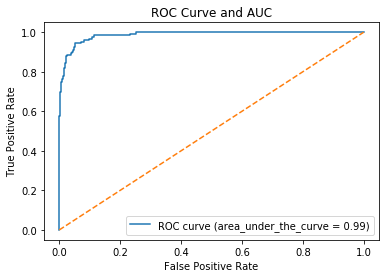

In [734]:
print("Confusion Matrix on Train Data=")
print(confusion_matrix(semi_train_y,ypred_train))

fpr_train, tpr_train, threashold = roc_curve(semi_train_y,yscore_train[:,1])
area_under_the_curve = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, label='ROC curve (area_under_the_curve = %0.2f)' % area_under_the_curve)
plt.plot([0,1], [0,1], "--")
plt.title("ROC Curve and AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Here,the values for the confusion matrix are: True Negative=395,False Positive=51,False Negative=3,True Positive=120

decision_function reference from https://stackoverflow.com/questions/32074239/sklearn-getting-distance-of-each-point-from-decision-boundary

Confusion Matrix on Test Data=
[[56 15]
 [ 2 40]]


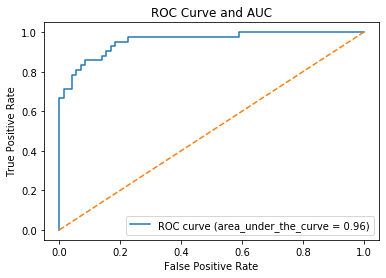

In [735]:
print("Confusion Matrix on Test Data=")
print(confusion_matrix(test_y,ypred_test))

fpr_test, tpr_test, threashold = roc_curve(test_y,yscore_test[:,1])
area_under_the_curve = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, label='ROC curve (area_under_the_curve = %0.2f)' % area_under_the_curve)
plt.plot([0,1], [0,1], "--")
plt.title("ROC Curve and AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Here,the values for the confusion matrix are: True Negative=56,False Positive=15,False Negative=2,True Positive=40

### (b) (iii) Monte-Carlo Simulation-Unsupervised Learning

We run the algorithm multiple times with different inital centroild values to ensure that it is not trapped in a local minimum. I have used init='random' which chooses initial centroids from the data randomly. Additionally, I have used n_init=100 which means the algorithm will be run with different centroid seed 100 times. 

In [736]:
%%time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
acc_score_train=[]
acc_score_test=[]
pscore_train=[]
pscore_test=[]
rscore_train=[]
rscore_test=[]
f1score_train=[]
f1score_test=[]
auc_train=[]
auc_test=[]

for m in range(1,31):
    y_pred_test=[]
    mali_data = df.loc[df["diagnosis"] == 1]    
    beni_data = df.loc[df["diagnosis"] == 0]
    test_data=pd.concat([mali_data.sample(frac=0.2),beni_data.sample(frac=0.2)])
    test_index=test_data.index
    train_data=df.drop(index=test_index)
    y_train=train_data.iloc[:,0:1]
    x_train=train_data.iloc[:,1:31]
    y_test=test_data.iloc[:,0:1]
    x_test=test_data.iloc[:,1:31]
    x_train=preprocessing.normalize(x_train)
    normalized_x_test=preprocessing.normalize(x_test)
    kmeans = KMeans(n_clusters=2, init='random', max_iter=100,n_jobs=-1,n_init=100)
    kmeans.fit(x_train)
    # Finding the 30 nearest neighbours using NearestNeighbours
    nbrs = NearestNeighbors(n_neighbors=30, algorithm='auto')
    nbrs.fit(x_train)
    distance_from_centroid,point_index=nbrs.kneighbors(kmeans.cluster_centers_)  #cluster centroid found by using kmeans.cluster_centeres
    # Reading the true labels of the 30 datapoints for the train set
    true_label_cluster0=y_train.iloc[point_index[0]]
    true_label_cluster1=y_train.iloc[point_index[1]]    
    # Majority polling for the cluster label
    majority_cluster0=true_label_cluster0['diagnosis'].value_counts().idxmax()
    majority_cluster1=true_label_cluster1['diagnosis'].value_counts().idxmax()
    # Assigning the labels for each k means cluster
    df_1 = pd.DataFrame()
    df_1['Index'] = train_data.index.values
    df_1['Cluster'] = kmeans.labels_
    cluster0_index = df_1[df_1['Cluster']==0]['Index'].values    
    cluster1_index =  df_1[df_1['Cluster']==1]['Index'].values
    df_2=pd.DataFrame()
    df_3=train_data.append(df_2)
    df_3.loc[cluster0_index,'diagnosis']=majority_cluster0
    df_3.loc[cluster1_index,'diagnosis']=majority_cluster1
    y_true_train=y_train.values
    y_pred_train=df_3['diagnosis'].values
    y_true_test=y_test.values
    # Predict the lables for the test set
    y_predict=kmeans.predict(x_test)
    # Assign the majority class of the train dataset clusters to test dataset clusters
    for i in range(len(y_predict)):
        if y_predict[i]==0:
            y_pred_test.append(majority_cluster0)
        else:
            y_pred_test.append(majority_cluster1)
    y_pred_test=np.array(y_pred_test)
 
    acc_sc_train=accuracy_score(y_true_train,y_pred_train)
    acc_score_train.append(acc_sc_train)
    acc_sc_test=accuracy_score(y_true_test,y_pred_test)
    acc_score_test.append(acc_sc_test)
    
    p_score_train=precision_score(y_true_train,y_pred_train)
    pscore_train.append(p_score_train)
    p_score_test=precision_score(y_true_test,y_pred_test)
    pscore_test.append(p_score_test)
    
    r_score_train=recall_score(y_true_train,y_pred_train)
    rscore_train.append(r_score_train)
    r_score_test=recall_score(y_true_test,y_pred_test)
    rscore_test.append(r_score_test)

    f1_score_train=f1_score(y_true_train,y_pred_train)
    f1score_train.append(f1_score_train)
    f1_score_test=f1_score(y_true_test,y_pred_test)
    f1score_test.append(f1_score_test)
   
    auc_tr = roc_auc_score(y_true_train,y_pred_train)
    auc_train.append(auc_tr)
    auc_te = roc_auc_score(y_true_test,y_pred_test)
    auc_test.append(auc_te)
    
print("Average Accuracy Score on Train Data=",np.mean(acc_score_train))
print("Average Accuracy Score on Test Data=",np.mean(acc_score_test))
print("Average Precision Score on Train Data=",np.mean(pscore_train))
print("Average Precision Score on Test Data=",np.mean(pscore_test))
print("Average Recall Score on Train Data=",np.mean(rscore_train))
print("Average Recall Score on Test Data=",np.mean(rscore_test))
print("Average F1 Score on Train Data=",np.mean(f1score_train))
print("Average F1 Score on Test Data=",np.mean(f1score_test))
print("Average AUC on Train Data=",np.mean(auc_train))
print("Average AUC on Test Data=",np.mean(auc_test))


Average Accuracy Score on Train Data= 0.8869152046783627
Average Accuracy Score on Test Data= 0.8787610619469027
Average Precision Score on Train Data= 0.9584865133297584
Average Precision Score on Test Data= 0.9679303354119325
Average Recall Score on Train Data= 0.7286274509803923
Average Recall Score on Test Data= 0.6976190476190476
Average F1 Score on Train Data= 0.8275342235103457
Average F1 Score on Test Data= 0.8087734593178963
Average AUC on Train Data= 0.8548148909913617
Average AUC on Test Data= 0.841767270288397
Wall time: 20 s


Confusion Matrix on Train Data=
[[284   2]
 [ 48 122]]


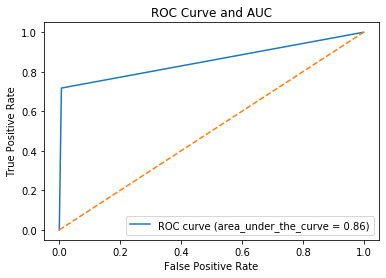

In [737]:
print("Confusion Matrix on Train Data=")
print(confusion_matrix(y_true_train,y_pred_train))

fpr_train, tpr_train, threashold = roc_curve(y_true_train,y_pred_train)
area_under_the_curve = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, label='ROC curve (area_under_the_curve = %0.2f)' % area_under_the_curve)
plt.plot([0,1], [0,1], "--")
plt.title("ROC Curve and AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Here,the values for the confusion matrix are: True Negative=284,False Positive=2,False Negative=48,True Positive=122

Confusion Matrix on Test Data=
[[70  1]
 [19 23]]


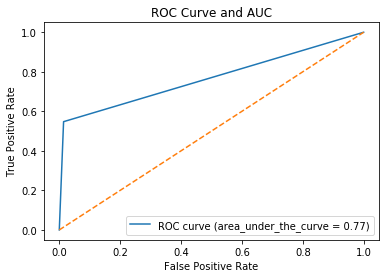

In [738]:
print("Confusion Matrix on Test Data=")
print(confusion_matrix(y_true_test,y_pred_test))

fpr_train, tpr_train, threashold = roc_curve(y_true_test,y_pred_test)
area_under_the_curve = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, label='ROC curve (area_under_the_curve = %0.2f)' % area_under_the_curve)
plt.plot([0,1], [0,1], "--")
plt.title("ROC Curve and AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Here,the values for the confusion matrix are: True Negative=70,False Positive=1,False Negative=19,True Positive=23

### (b) (iv) Monte-Carlo Simulation-Spectral Clustering

In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster. For instance when clusters are nested circles on the 2D plane.

SpectralClustering requires the number of clusters to be specified. It works well for a small number of clusters but is not advised when using many clusters.

reference from https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

In [848]:
from sklearn.cluster import SpectralClustering
import random
pred_index0=[]
pred_index1=[]
acc_score_train=[]
acc_score_test=[]
pscore_train=[]
pscore_test=[]
rscore_train=[]
rscore_test=[]
f1score_train=[]
f1score_test=[]
auc_train=[]
auc_test=[]
for m in range(1,31):
    malignant_data = df.loc[df["diagnosis"] == 1]    
    benign_data = df.loc[df["diagnosis"] == 0]
    test_data=pd.concat([malignant_data.sample(frac=0.2),benign_data.sample(frac=0.2)])
    test_index=test_data.index
    train_data=df.drop(index=test_index)
    train_y=train_data.iloc[:,0:1]
    train_x=train_data.iloc[:,1:31]
    test_y=test_data.iloc[:,0:1]
    test_x=test_data.iloc[:,1:31]
    normalized_train_x=preprocessing.normalize(train_x)
    normalized_test_x=preprocessing.normalize(test_x)

    clustering = SpectralClustering(n_clusters=2, gamma=1, affinity='rbf', assign_labels="kmeans", n_jobs=-1)
    y_pred=clustering.fit_predict(normalized_train_x)
    ypred=clustering.fit_predict(normalized_test_x)
    # Finding the index positions of labels 0 and 1
    for i in range(len(y_pred)):
        if y_pred[i]==0:
            pred_index0 = np.where(y_pred==0)[0]
        else:
            pred_index1 = np.where(y_pred==1)[0]
    # Selecting 30 points randomly from each label
    random_sample0_index = random.choices(pred_index0, k=30)
    random_sample1_index = random.choices(pred_index1, k=30)
    # Finding the true labels of the 30 samples from train_y
    true_label_cluster0=train_y.iloc[random_sample0_index]
    true_label_cluster1=train_y.iloc[random_sample1_index] 
    # Determining the majority class of the true labels
    majority_cluster0=true_label_cluster0['diagnosis'].value_counts().idxmax()
    majority_cluster1=true_label_cluster1['diagnosis'].value_counts().idxmax()
    # Assigning the labels for each spectral cluster for train data
    df_4 = pd.DataFrame()
    df_4['Index'] = train_data.index.values
    df_4['Cluster'] = y_pred
    cluster0_index = df_4[df_4['Cluster']==0]['Index'].values    
    cluster1_index =  df_4[df_4['Cluster']==1]['Index'].values
    df_5=pd.DataFrame()
    df_s=train_data.append(df_5)
    df_s.loc[cluster0_index,'diagnosis']=majority_cluster0
    df_s.loc[cluster1_index,'diagnosis']=majority_cluster1
    y_true_train=train_y.values
    y_pred_train=df_s['diagnosis'].values
    
    # Assigning the labels for each spectral cluster for test data
    df_6 = pd.DataFrame()
    df_6['Index'] = test_data.index.values
    df_6['Cluster'] = ypred
    cluster0_index_test = df_6[df_6['Cluster']==0]['Index'].values    
    cluster1_index_test =  df_6[df_6['Cluster']==1]['Index'].values

    df_7=pd.DataFrame()
    df_s_test=test_data.append(df_7)
    df_s_test.loc[cluster0_index_test,'diagnosis']=majority_cluster0
    df_s_test.loc[cluster1_index_test,'diagnosis']=majority_cluster1
    y_true_test=test_y.values
    y_pred_test=df_s_test['diagnosis'].values

    acc_sc_train=accuracy_score(y_true_train,y_pred_train)
    acc_score_train.append(acc_sc_train)
    acc_sc_test=accuracy_score(y_true_test,y_pred_test)
    acc_score_test.append(acc_sc_test)
    
    p_score_train=precision_score(y_true_train,y_pred_train)
    pscore_train.append(p_score_train)
    p_score_test=precision_score(y_true_test,y_pred_test)
    pscore_test.append(p_score_test)
    
    r_score_train=recall_score(y_true_train,y_pred_train)
    rscore_train.append(r_score_train)
    r_score_test=recall_score(y_true_test,y_pred_test)
    rscore_test.append(r_score_test)

    f1_score_train=f1_score(y_true_train,y_pred_train)
    f1score_train.append(f1_score_train)
    f1_score_test=f1_score(y_true_test,y_pred_test)
    f1score_test.append(f1_score_test)
   
    auc_tr = roc_auc_score(y_true_train,y_pred_train)
    auc_train.append(auc_tr)
    auc_te = roc_auc_score(y_true_test,y_pred_test)
    auc_test.append(auc_te)
    
print("Average Accuracy Score on Train Data=",np.mean(acc_score_train))
print("Average Accuracy Score on Test Data=",np.mean(acc_score_test))
print("Average Precision Score on Train Data=",np.mean(pscore_train))
print("Average Precision Score on Test Data=",np.mean(pscore_test))
print("Average Recall Score on Train Data=",np.mean(rscore_train))
print("Average Recall Score on Test Data=",np.mean(rscore_test))
print("Average F1 Score on Train Data=",np.mean(f1score_train))
print("Average F1 Score on Test Data=",np.mean(f1score_test))
print("Average AUC on Train Data=",np.mean(auc_train))
print("Average AUC on Test Data=",np.mean(auc_test))

Average Accuracy Score on Train Data= 0.8817982456140352
Average Accuracy Score on Test Data= 0.6321533923303836
Average Precision Score on Train Data= 0.9596949432024208
Average Precision Score on Test Data= 0.6805308186996513
Average Recall Score on Train Data= 0.7129411764705884
Average Recall Score on Test Data= 0.5865079365079365
Average F1 Score on Train Data= 0.8179749341555572
Average F1 Score on Test Data= 0.6148606548078324
Average AUC on Train Data= 0.8475545043192104
Average AUC on Test Data= 0.6228314330427007


Confusion Matrix on Train Data=
[[280   6]
 [ 48 122]]


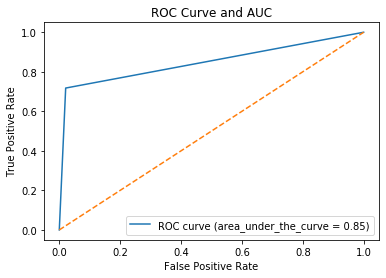

In [849]:
print("Confusion Matrix on Train Data=")
print(confusion_matrix(y_true_train,y_pred_train))

fpr_train, tpr_train, threashold = roc_curve(y_true_train,y_pred_train)
area_under_the_curve = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, label='ROC curve (area_under_the_curve = %0.2f)' % area_under_the_curve)
plt.plot([0,1], [0,1], "--")
plt.title("ROC Curve and AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Here,the values for the confusion matrix are: True Negative=280,False Positive=6,False Negative=48,True Positive=122

Confusion Matrix on Test Data=
[[71  0]
 [12 30]]


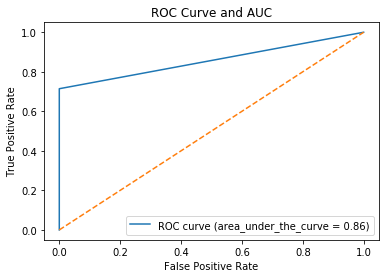

In [850]:
print("Confusion Matrix on Test Data=")
print(confusion_matrix(y_true_test,y_pred_test))

fpr_train, tpr_train, threashold = roc_curve(y_true_test,y_pred_test)
area_under_the_curve = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, label='ROC curve (area_under_the_curve = %0.2f)' % area_under_the_curve)
plt.plot([0,1], [0,1], "--")
plt.title("ROC Curve and AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Here,the values for the confusion matrix are: True Negative=71,False Positive=0,False Negative=12,True Positive=30

### (b) (v) Monte-Carlo Simulation-Results

In [856]:
df_results_train=pd.DataFrame({'Supervised':[0.962,0.963,0.956,0.959,0.996],'Semi-Supervised':[0.922,0.892,0.922,0.900,0.986],
                'Unsupervised(K-means)':[0.887,0.958,0.729,0.828,0.855],'Spectral Clustering':[0.882,0.960,0.713,0.818,0.848]}, 
                index=['Accuracy Score','Precision Score','Recall Score','F1 Score','AUC'])
df_results_train

,Supervised,Semi-Supervised,Unsupervised(K-means),Spectral Clustering
Accuracy Score,0.962,0.922,0.887,0.882
Precision Score,0.963,0.892,0.958,0.960
Recall Score,0.956,0.922,0.729,0.713
F1 Score,0.959,0.900,0.828,0.818
AUC,0.996,0.986,0.855,0.848


We can observe that Supervised Learning gives us the best results followed by Semi-Supervised Learning for training data. K-means Clustering and Spectral Clustering almost give the same result, K-means is slightly better. 

In [859]:
df_results_test=pd.DataFrame({'Supervised':[0.943,0.943,0.935,0.938,0.991],'Semi-Supervised':[0.842,0.849,0.842,0.832,0.947],
                'Unsupervised(K-means)':[0.879,0.968,0.698,0.809,0.842],'Spectral Clustering':[0.632,0.681,0.587,0.615,0.623]},
                index=['Accuracy Score','Precision Score','Recall Score','F1 Score','AUC'])
df_results_test

,Supervised,Semi-Supervised,Unsupervised(K-means),Spectral Clustering
Accuracy Score,0.943,0.842,0.879,0.632
Precision Score,0.943,0.849,0.968,0.681
Recall Score,0.935,0.842,0.698,0.587
F1 Score,0.938,0.832,0.809,0.615
AUC,0.991,0.947,0.842,0.623


We get the best test results from Supervised Learning followed by Semi-Supervised Learning. As expected Unsupervised Learning underperforms especially in the case of Spectral clustering. 